In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import sys
import os
from pathlib import Path

from nilearn.plotting import plot_connectome

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
    
from dn_utils.plotting import aligned_imshow_cbar
from dn_utils.style import BLUE, ORANGE
%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
def distance(r1, r2):
    '''Euclidean distance between two points in 3D space.'''
    return math.sqrt(sum(c ** 2 for c in (c1 - c2 for c1, c2 in zip(r1, r2)))) 

def sphere_radius(volume):
    '''Radius of sphere with specified volume.'''
    return (volume * (3 / 4) / math.pi) ** (1 / 3)

In [11]:
path_derivatives = os.path.join(path_root, 'data/main_fmri_study/derivatives')
path_meta_roi = os.path.join(path_derivatives, 'ppi/parcellations/meta_roi')
roi_table_fname = os.path.join(path_meta_roi, 'meta_roi_table.csv')
roi_labels_fname = os.path.join(path_meta_roi, 'meta_roi_labels.txt')
roi_coords_fname = os.path.join(path_meta_roi, 'meta_roi_coords.txt')

Path(path_meta_roi).mkdir(parents=True, exist_ok=True)

### Meta analysis data

Meta-analysis ALE data from Fouragnan et al., 2018 – "Separate representations of prediction error valence and surprise: Evidence from an fMRI meta analysis".

Table 2 data presenting ALE clusters for patterns:
- NEG > POS
- POS > NEG

In [4]:
ale_clusters_dec_data = [
    ['dMCC', 'Dorsomedial cingulate cortex', 'R', 2, 24, 36, 12712, 0.051],
    ['aINS', 'Anterior insula', 'R', 32, 24, -2, 6120, 0.062],
    ['aINS', 'Anterior insula', 'L', -32, 22, -4, 4880, 0.056],
    ['PAL', 'Pallidum', 'R', 12, 8, 4, 3360, 0.04],
    ['PAL', 'Pallidum', 'L', -14, 6, 2, 2520, 0.029],
    ['mFG1', 'Middle frontal gyrus 1', 'R', 38, 4, 32, 3152, 0.029],
    ['mFG2', 'Middle frontal gyrus 2', 'R', 30, 10, 56, 488, 0.021],
    ['mFG', 'Middle frontal gyrus', 'L', -28, 12, 60, 104, 0.019],
    ['IPL', 'Inferior parietal lobule', 'R', 40, -48, 42, 2416, 0.039],
    ['IPL', 'Inferior parietal lobule', 'L', -38, -48, 42, 2216, 0.043],
    ['mTG', 'Middle temporal gyrus', 'R', 60, -28, -6, 1192, 0.031],
    ['AMYG', 'Amygdala', 'R', 18, -6, -12, 704, 0.024],
    ['THA1', 'Thalamus 1', 'L', -12, -12, 10, 624, 0.025],
    ['THA2', 'Thalamus 2', 'L', -6, -26, 8, 280, 0.023],
    ['HAB', 'Habenula', 'R', 2, -20, -18, 312, 0.022],
    ['dlPFC', 'Dorsolateral prefrontal cortex', 'L', -44, 28, 32, 360, 0.020],
    ['dlPFC', 'Dorsolateral prefrontal cortex', 'R', 40, 34, 30, 344, 0.020],
    ['FUS', 'Fusiform area', 'L', -40, -62, -10, 272, 0.023],
    ['PREC', 'Precentral cortex', 'L', -52, 0, 34, 256, 0.021],
    ['dmOFC', 'Dorsomedial orbitofrontal cortex', 'R', 38, 58, -2, 192, 0.020],
    ['dmPFC', 'Dorsomedial prefrontal cortex', 'R', 20, 50, 4, 120, 0.018],
    ['STS', 'Superior temporal sulcus', 'R', 58, -42, 22, 120, 0.017],
]

ale_clusters_inc_data = [
    ['vSTR', 'Ventral striatum', 'L', -12, 8, -4, 4880, 0.052],
    ['vSTR', 'Ventral striatum', 'R', 8, 8, -2, 2880, 0.038],
    ['vmPFC', 'Ventromedial prefrontal cortex', 'L', -2, 42, 0, 3416, 0.037],
    ['PCC', 'Posterior cingulate cortex 1', 'L', 0, -32, 36, 240, 0.016],
    ['PCC', 'Posterior cingulate cortex 2', 'L', 0, -36, 26, 88, 0.014],
    ['vlOFC', 'Ventrolateral orbitofrontal cortex', 'R', 32, 44, -10, 144, 0.015],
    ['dmPFC', 'Dorsomedial prefrontal cortex', 'L', -6, -56, 14, 96, 0.016],
    ['mPFC', 'Medial prefrontal cortex', 'L', -2, 46, 20, 88, 0.014],
]


for row in ale_clusters_dec_data:
    row.append('perr_dec')
for row in ale_clusters_inc_data:
    row.append('perr_inc')

columns = ['abbrev', 'name', 'hemisphere', 'x', 'y', 'z', 'cluster_size', 
           'ale_score', 'netName']
df_rois = pd.DataFrame(
    [{k: v for k, v in zip(columns, row)} for row in ale_clusters_dec_data] \
  + [{k: v for k, v in zip(columns, row)} for row in ale_clusters_inc_data])

df_rois['approxRadius'] = df_rois['cluster_size'].map(sphere_radius)
df_rois['radius(mm)'] = 4
df_rois

,abbrev,name,hemisphere,x,y,z,cluster_size,ale_score,netName,approxRadius,radius(mm)
0,dMCC,Dorsomedial cingulate cortex,R,2,24,36,12712,0.051,perr_dec,14.477995,4
1,aINS,Anterior insula,R,32,24,-2,6120,0.062,perr_dec,11.347171,4
2,aINS,Anterior insula,L,-32,22,-4,4880,0.056,perr_dec,10.522293,4
3,PAL,Pallidum,R,12,8,4,3360,0.040,perr_dec,9.291451,4
4,PAL,Pallidum,L,-14,6,2,2520,0.029,perr_dec,8.441844,4
5,mFG1,Middle frontal gyrus 1,R,38,4,32,3152,0.029,perr_dec,9.095625,4
6,mFG2,Middle frontal gyrus 2,R,30,10,56,488,0.021,perr_dec,4.884016,4
7,mFG,Middle frontal gyrus,L,-28,12,60,104,0.019,perr_dec,2.917303,4
8,IPL,Inferior parietal lobule,R,40,-48,42,2416,0.039,perr_dec,8.324077,4
9,IPL,Inferior parietal lobule,L,-38,-48,42,2216,0.043,perr_dec,8.087738,4


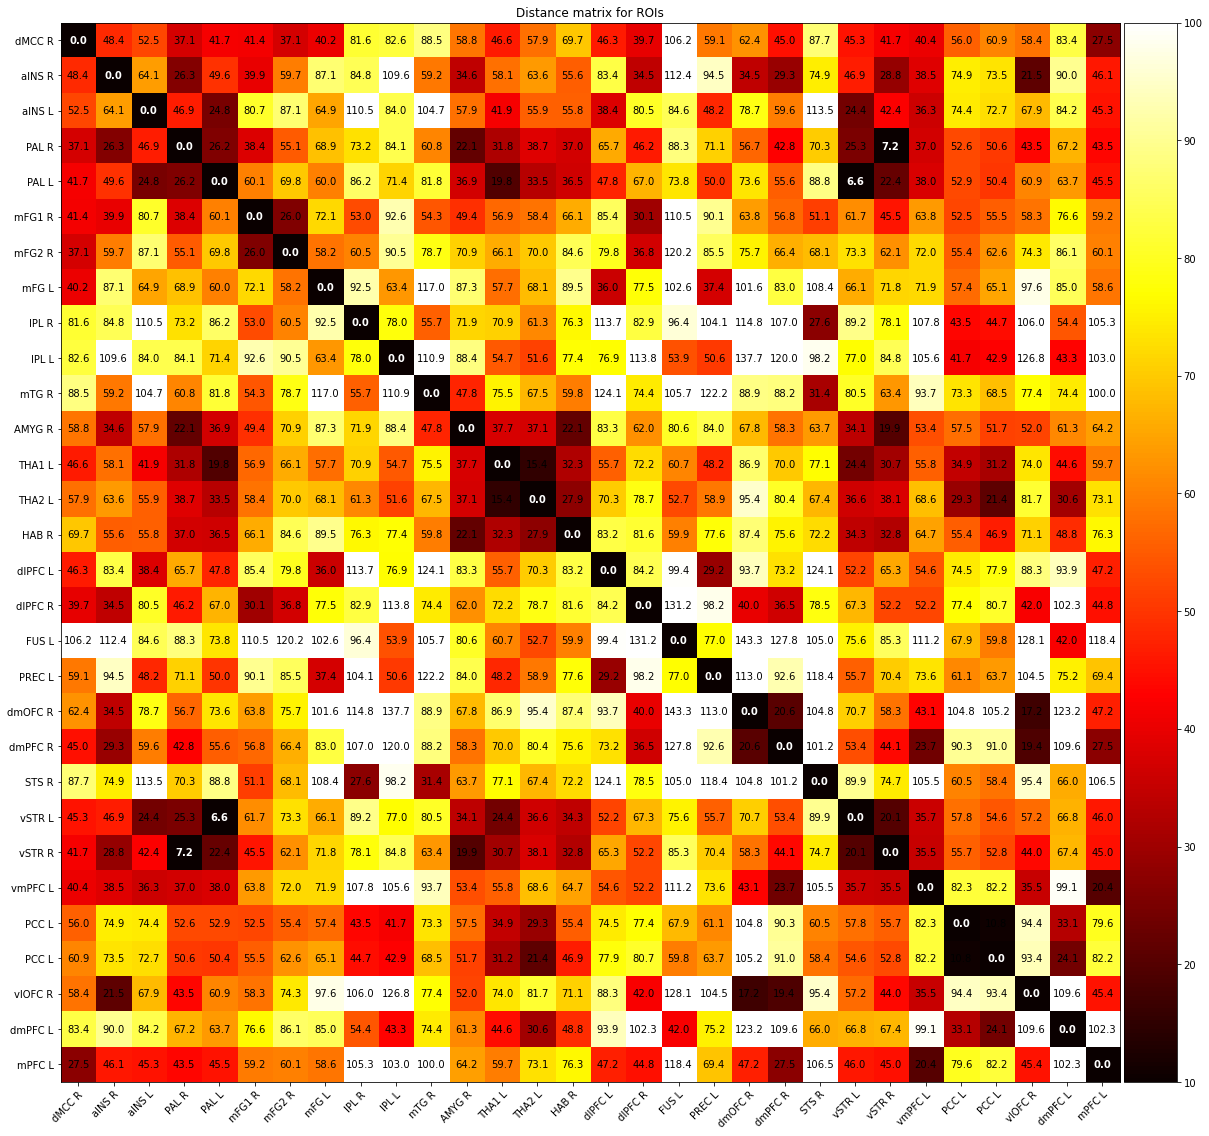

In [5]:
n_rois = len(df_rois)

distance_matrix = np.zeros((n_rois, n_rois))

for i in range(n_rois):
    for j in range(i, n_rois):
        distance_matrix[i, j] = distance(
            df_rois.loc[i, ['x', 'y', 'z']],
            df_rois.loc[j, ['x', 'y', 'z']]
        )
distance_matrix = distance_matrix + distance_matrix.T        
        
fig, ax = plt.subplots(figsize=(20, 20))
im = plt.imshow(distance_matrix, cmap='hot', clim=[10, 100])
aligned_imshow_cbar(ax, im)

for i in range(n_rois):
    for j in range(n_rois):
        if distance_matrix[i, j] < 10:
            annotation_color = 'w'
            fontWeight = 'bold'
        else:
            annotation_color = 'k'
            fontWeight = 'normal'
        text = ax.text(j, i, f'{distance_matrix[i, j]:2.1f}', 
                       ha='center', va='center', color=annotation_color, 
                       fontWeight=fontWeight)
        
ax.set_xticks(np.arange(n_rois))
ax.set_yticks(np.arange(n_rois))
ax.set_yticklabels(df_rois['abbrev'] + ' ' + df_rois['hemisphere'])
ax.set_xticklabels(df_rois['abbrev'] + ' ' + df_rois['hemisphere'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title('Distance matrix for ROIs')
plt.show()

In [6]:
# Fix radius for overlapping ROIs
df_rois.loc[df_rois['abbrev'] == 'PAL', 'radius(mm)'] = 3
df_rois.loc[df_rois['abbrev'] == 'vSTR', 'radius(mm)'] = 3

# Save atlas
df_rois.to_csv(roi_table_fname, index=False)

In [21]:
with open(roi_labels_fname, 'w') as f:
    f.write('\n'.join(df_rois['abbrev'] + '_' + df_rois['hemisphere']))
    
with open(roi_coords_fname, 'w') as f:
    f.write('\n'.join(df_rois[['x', 'y', 'z']].astype(str).agg(' '.join, axis=1)))

### Show custom ROIs on in brain space

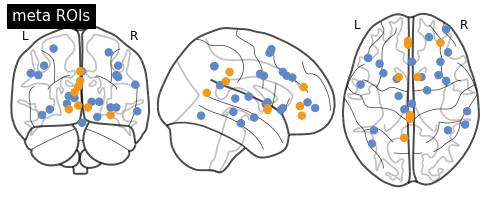

In [7]:
adjacency_matrix = np.zeros((n_rois, n_rois))
node_coords = np.array(df_rois.loc[:, ['x', 'y', 'z']])
node_color = df_rois['netName'].map(lambda net: BLUE if net == 'perr_dec' else ORANGE)
node_size = 55

plot_connectome(
    adjacency_matrix=adjacency_matrix,
    node_coords=node_coords,
    node_color=list(node_color), 
    node_size=node_size,
    title='meta ROIs',
    display_mode='ortho'
)
plt.show()